In [1]:
print("All ok")

All ok


In [2]:
from euriai import EuriaiClient
from dotenv import load_dotenv
import os
load_dotenv()

# Initialize client
client = EuriaiClient(
    api_key=os.getenv("EURI_API_KEY"),
    model="gpt-4.1-nano"
)

# Generate completion
response = client.generate_completion(
    prompt="What is artificial intelligence?",
    temperature=0.7,
    max_tokens=1000
)

print(response["choices"][0]["message"]["content"])

Artificial Intelligence (AI) refers to the branch of computer science and engineering focused on creating systems and machines that can perform tasks typically requiring human intelligence. These tasks include learning from experience, recognizing patterns, understanding language, reasoning, problem-solving, and decision-making. AI can be categorized into narrow AI, which is designed for specific tasks (like virtual assistants or image recognition), and general AI, which would possess the ability to understand, learn, and apply intelligence across a wide range of activities similar to human cognition. The goal of AI is to develop systems that can perform complex tasks efficiently and autonomously, often improving over time through data and experience.


In [27]:
from euriai.langchain import EuriaiChatModel

chat_llm = EuriaiChatModel(
    api_key=os.getenv("EURI_API_KEY"),
    model="gpt-4.1-nano"
)

In [28]:
chat_llm.invoke("How are you?").content

"I'm doing well, thank you! How can I assist you today?"

In [5]:
from typing_extensions import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage,HumanMessage, AIMessage

In [6]:
class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage],operator.add]

In [29]:
# Node creation
def llm_call(state: GraphState) -> dict:
    """Call the LLm using conversation message and append AI response."""
    response = chat_llm.invoke(state["messages"])
    return{
        "messages" : [response]
    }


In [30]:
def token_counter(state: GraphState) -> dict:
    """count tokens (simple word count) in the last AI message"""
    last_msg = state["messages"][-1]
    test = last_msg.content
    token_number = len(test.split())
    summary = f"Total token number in the generated answer(word count) is {token_number} "
    return {
        "messages" : [AIMessage(content=summary)]
    }

In [31]:
from langgraph.graph import StateGraph

In [32]:
builder = StateGraph(GraphState)

In [33]:
builder.add_node("llm_call", llm_call)
builder.add_node("token_counter", token_counter)

In [34]:
builder.set_entry_point("llm_call")
builder.add_edge("llm_call", "token_counter")
builder.set_finish_point("token_counter")

In [35]:
app = builder.compile()

In [36]:
app.get_graph()

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=RunnableCallable(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'llm_call': Node(id='llm_call', name='llm_call', data=llm_call(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'token_counter': Node(id='token_counter', name='token_counter', data=token_counter(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=None, metadata=None)}, edges=[Edge(source='__start__', target='llm_call', data=None, conditional=False), Edge(source='llm_call', target='token_counter', data=None, conditional=False), Edge(source='token_counter', target='__end__', data=None, conditional=False)])

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=RunnableCallable(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'llm_call': Node(id='llm_call', name='llm_call', data=llm_call(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'token_counter': Node(id='token_counter', name='token_counter', data=token_counter(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=None, metadata=None)}, edges=[Edge(source='__start__', target='llm_call', data=None, conditional=False), Edge(source='llm_call', target='token_counter', data=None, conditional=False), Edge(source='token_counter', target='__end__', data=None, conditional=False)])

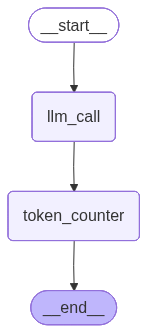

In [37]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [38]:
result = app.invoke({
    "messages": [HumanMessage(content="What is the capital of India?")]
    })


In [39]:
result


{'messages': [HumanMessage(content='What is the capital of India?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='The capital of India is New Delhi.', additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 16, 'completion_tokens': 8, 'total_tokens': 24}, 'model_name': 'gpt-4.1-nano', 'system_fingerprint': None, 'finish_reason': 'stop', 'model': 'gpt-4.1-nano', 'created': 1771338267}, id='lc_run--019c6bfc-f164-7672-a74b-4428a22ca78b-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 16, 'output_tokens': 8, 'total_tokens': 24}),
  AIMessage(content='Total token number in the generated answer(word count) is 7 ', additional_kwargs={}, response_metadata={}, tool_calls=[], invalid_tool_calls=[])]}

In [40]:
for m in result["messages"]:
    print(type(m).__name__, ":", m.content)

HumanMessage : What is the capital of India?
AIMessage : The capital of India is New Delhi.
AIMessage : Total token number in the generated answer(word count) is 7 


In [41]:
chat_llm

EuriaiChatModel(api_key='euri-c9568033197a7bd5b55a1fd3448354ba76d34cba1d8728f60381333d40437870')

### Tool Calling

In [ ]:
# Loading lanchain inbuilt tool
from langchain_community.tools import WikipediaQueryRun # to get information from wikipedia
from langchain_community.utilities import WikipediaAPIWrapper


In [45]:
api_wrapper = WikipediaAPIWrapper(top_k_results = 5, doc_content_chars_max = 500)

In [46]:
wiki_tool = WikipediaQueryRun(api_wrapper = api_wrapper)

In [50]:
wiki_tool.run("Generative AI")

'Page: Generative artificial intelligence\nSummary: Generative artificial intelligence, also known as generative AI or GenAI, is a subfield of artificial intelligence that uses generative models to generate text, images, videos, audio, software code or other forms of data. These models learn the underlying patterns and structures of their training data, and use them to generate new data in response to input, which often takes the form of natural language prompts.\nThe prevalence of generative AI to'

In [51]:
wiki_tool.run({"query":"Generative AI"})

'Page: Generative artificial intelligence\nSummary: Generative artificial intelligence, also known as generative AI or GenAI, is a subfield of artificial intelligence that uses generative models to generate text, images, videos, audio, software code or other forms of data. These models learn the underlying patterns and structures of their training data, and use them to generate new data in response to input, which often takes the form of natural language prompts.\nThe prevalence of generative AI to'

'Page: Generative artificial intelligence\nSummary: Generative artificial intelligence, also known as generative AI or GenAI, is a subfield of artificial intelligence that uses generative models to generate text, images, videos, audio, software code or other forms of data. These models learn the underlying patterns and structures of their training data, and use them to generate new data in response to input, which often takes the form of natural language prompts.\nThe prevalence of generative AI to'

#### Tavily is currently the industry standard for giving LLMs access to the internet.

In [ ]:
import os 
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv
load_dotenv()
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")

In [64]:
TAVILY_API_KEY

'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'

In [144]:
internet_search_tool = TavilySearchResults(TAVILY_API_KEY = TAVILY_API_KEY)

In [145]:
internet_search_tool.name

'tavily_search_results_json'

In [146]:
internet_search_tool.description

'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.'

'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.'

In [147]:
job = internet_search_tool.invoke({"query":"how is the job market for fresher graduates in 2026"})

In [84]:
job

[{'title': 'The 2026 Job Market: Supporting Students and Closing the Skills Gap',
  'url': 'https://findingequilibriumfuturehighered.substack.com/p/the-2026-job-market-supporting-students',
  'content': "# Finding Equilibrium: Two Economists on Higher Ed's Future\n\n# The 2026 Job Market: Supporting Students and Closing the Skills Gap\n\n### Ideas for Preparing More Career-Ready Graduates\n\nJay Akridge and David Hummels\n\nDec 19, 2025\n\nWe’ve written a couple of times this fall on the current job market for new college graduates. The bottom-line: the Class of 2026 is likely to have more trouble finding a job.\n\nStudents are concerned: about 61% of the Class of 2026 students find current news about the job market somewhat or very pessimistic – up from 50% for the Class of 2024. High competition for jobs and lack of available jobs top the list of reasons for that pessimism, with the political climate and AI much more important factors this year relative to last.\n\nSource: Handshake.

In [100]:
for i in job:
    print(i["title"], "----------", i["content"])


The 2026 Job Market: Supporting Students and Closing the Skills Gap ---------- # Finding Equilibrium: Two Economists on Higher Ed's Future

# The 2026 Job Market: Supporting Students and Closing the Skills Gap

### Ideas for Preparing More Career-Ready Graduates

Jay Akridge and David Hummels

Dec 19, 2025

We’ve written a couple of times this fall on the current job market for new college graduates. The bottom-line: the Class of 2026 is likely to have more trouble finding a job.

Students are concerned: about 61% of the Class of 2026 students find current news about the job market somewhat or very pessimistic – up from 50% for the Class of 2024. High competition for jobs and lack of available jobs top the list of reasons for that pessimism, with the political climate and AI much more important factors this year relative to last.

Source: Handshake. [...] #### Some Final Thoughts

A soft job market for graduates is nothing new for universities, but it certainly will be new for members 

In [101]:
# Langchain inbuilt tool:---- DuckDuckDoSearch

from langchain_community.tools import DuckDuckGoSearchRun
search = DuckDuckGoSearchRun()

In [124]:
search.name
search.description

'A wrapper around DuckDuckGo Search. Useful for when you need to answer questions about current events. Input should be a search query.'

'A wrapper around DuckDuckGo Search. Useful for when you need to answer questions about current events. Input should be a search query.'

In [108]:
search.invoke({"query":"what is the temperture in bengaluru now?"})

"Today ’s and tonight’s Bengaluru , Karnataka 560300, India weather forecast, weather conditions and Doppler radar from The Weather Channel and weather .com Bengaluru , Karnataka, India Weather Forecast, with current conditions, wind, air quality, and what to expect for the next 3 days. 1 day ago · Bangalore weather today shows a temperature of 27.1°C with Sunny conditions. The current weather in Bangalore feels like 25.3°C, with humidity at 37%, wind blowing at 13.7 km/h, and a UV Index of 10.1. Visibility stands at 8 km. According to the latest Bangalore weather update, sunrise was at 06:41 AM and sunset is expected at 06:26 PM. These timings help residents plan their day better ... 1 day ago · How's the weather today in Bengaluru , Karnataka. We provide information on: wind speed, wind direction, atmospheric pressure, temperature , humidity and visibility. 1 day ago · Get the latest Bengaluru weather updates! Check today ’s forecast, temperature , humidity, hourly updates rain alert

In [113]:
search.invoke("what is the latest update on iphone17 release?")

'The iPhone 17 Pro Max release date is the same as the regular version, so fans don’t have to wait longer. ... the latest iPhone, the new iPhone 17 ... CyberIntro is a Web based Tech New Portal focuses on events and updates from Giant Tech Companies like Google, Facebook, Microsoft, Apple, etc., The device runs on iOS 26 , Apple ’ s latest ... The latest iPhone model as of now is the iPhone 15 series, released in September 2024. The official in-ster launch is expected a week later on September 19 (Friday). ... The price hike is being attributed to slow demand in some ... Current industry leaks suggest that Apple is on track to release the iPhone 17 in September 2025 , following its usual annual launch cycle.'

In [114]:
# You can use .run or .invoke
search.run("what is the latest update on iphone17 release?")

"Oct 9, 2025 · Apple’s 2025 iPhone lineup was announced at Apple’s “Awe Dropping” event on September 9, 2025. There are three new models including a brand-new iPhone category: the iPhone Air, the slimmest... Oct 1, 2025 · Thanks to the new A19 chip and an Apple-designed N1 networking chip, the iPhone 17 is more efficient for improved battery life. It lasts up to 30 hours when watching videos, or up to 27 hours... Apple’s iPhone 17 lineup is here. The tech giant has unveiled four new models that mark the latest editions to its marquee product. We covered the Apple event below, and you can read our minute-by-minute account below of all of the company's announcements, along with updates as we get some hands-on time with the new phones... Sep 9, 2025 · iPhone 17 introduces N1, a new Apple-designed wireless networking chip that enables Wi-Fi 7, Bluetooth 6, and Thread. In addition to the latest generation of wireless technologies, N1 improves the overall performance and reliability of featu

#### Lie wise you can use being search or googlserperapi
### you scan search for different  inbuilt tools in langchain

In [116]:
# inbuilt youtube search tool of langchain
from langchain_community.tools import YouTubeSearchTool

In [118]:
youtube_tool = YouTubeSearchTool()

In [120]:
youtube_tool.name

'youtube_search'

In [122]:
# you can get the description of every tool 
youtube_tool.description

'search for youtube videos associated with a person. the input to this tool should be a comma separated list, the first part contains a person name and the second a number that is the maximum number of video results to return aka num_results. the second part is optional'

'search for youtube videos associated with a person. the input to this tool should be a comma separated list, the first part contains a person name and the second a number that is the maximum number of video results to return aka num_results. the second part is optional'

In [119]:
youtube_tool.run("End to End MachineLearning Project")

"['https://www.youtube.com/watch?v=o6vbe5G7xNo&pp=ygUiRW5kIHRvIEVuZCBNYWNoaW5lTGVhcm5pbmcgUHJvamVjdA%3D%3D', 'https://www.youtube.com/watch?v=MJ1vWb1rGwM&pp=ygUiRW5kIHRvIEVuZCBNYWNoaW5lTGVhcm5pbmcgUHJvamVjdA%3D%3D']"

# Custom tool creation

In [166]:
def multiply(a:int, b:int)->int:
    """Multiplies two numbers"""
    return a*b

In [167]:
type(multiply)

function

In [133]:
multiply(2,3)

6

In [135]:
multiply.invoke({"a":2, "b":3})

AttributeError: 'function' object has no attribute 'invoke'

### Tool example

In [148]:
from langchain.tools import tool

In [168]:
@tool
def langchain_multiply(a:int, b:int)->int:
    """Multiplies two numbers"""
    return a*b

In [170]:
type(langchain_multiply)

langchain_core.tools.structured.StructuredTool

In [171]:
langchain_multiply.name

'langchain_multiply'

In [173]:
langchain_multiply.description

'Multiplies two numbers'

In [174]:
langchain_multiply.args

{'a': {'title': 'A', 'type': 'integer'},
 'b': {'title': 'B', 'type': 'integer'}}

In [169]:
langchain_multiply.invoke({"a":3,"b":5})

15

In [172]:
langchain_multiply.run({"a":3,"b": 5})

15

#### tool 2nd example

In [ ]:
@tool
def add(a, b)->int:
    """add two numbers"""
    return a+b

In [164]:
add.invoke({"a":2,"b":3})

5

#### Below is not a tool, it is just function

In [175]:
def get_word_length(word:str)->int:
    """Returns the length of the word"""
    return len(word)

In [177]:
type(get_word_length)

function

### Langchain tool

In [176]:
@tool
def lan_get_word_length(word:str)->int:
    """Returns the length of the word"""
    return len(word)

In [178]:
type(lan_get_word_length)

langchain_core.tools.structured.StructuredTool

In [179]:
lan_get_word_length.invoke({"word":"hello"})

5

In [180]:
lan_get_word_length.invoke("hello")

5

### Examples of tools 

In [ ]:
# This is a tool to call the gmail api
@tool
def call_gmail_api(args):
    """this tool calls the gmail api"""
    pass

In [181]:
# This tool calls the sqlite db api
@tool 
def call_sqllite_db(args):
    """this tool calls the sqlite db api"""
    pass

In [183]:
# To get the financial data in realtime
import yfinance as yf

In [189]:
@tool
def get_stock_price(ticker:str)->str:
    """this is a tool to get stock price using yfinance"""
    try:
        stock = yf.Ticker(ticker)

        #get last 1 day historical data
        data = stock.history(period="1d")

        if data.empty:
            return f"No data found for ticker '{ticker}'. please check the symbol."
        
        latest_close = data["Close"].iloc[-1]

        # Detect currency
        currency = stock.info.get("currency", "")
        symbol_map = {
            'INR' : "₹",
            'USD' : "$",
            'EUR' : "€",
            'JPY' : "¥",
            'GBP' : "£",
            'AUD' : "A$",
            'CAD' : "C$",
            'CHF' : "Fr.",
        }

        symbol = symbol_map.get(currency, "")
        currency_test = currency if currency else ""

        if symbol:
            return f"The last closing price of {ticker.upper()} was {symbol}{latest_close:.2f}."
        else:
            return f"The last closing price of {ticker.upper()} was {latest_close:.2f} {currency_test}."

    except Exception as e:
        return f"An error occurred while fetching stock data: {str(e)}"




In [212]:
get_stock_price.invoke({"ticker":"TCS.NS"})

'The last closing price of TCS.NS was ₹2722.70.'

In [213]:
get_stock_price.invoke({"ticker":"AAPL"})

'The last closing price of AAPL was $264.35.'

In [214]:
get_stock_price.invoke({"ticker":"TSLA"})

'The last closing price of TSLA was $411.32.'

In [215]:
get_stock_price.invoke({"ticker":"HDFCBANK.NS"})

'The last closing price of HDFCBANK.NS was ₹921.55.'